In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import numpy as np
import pickle
import pandas as pd
import tqdm.notebook as progress_bar
from matplotlib import pyplot as plt

# Cargar datos

## Embeddings

In [2]:
with open('data/index_item_and_embedding_matrix_dict.pickle', 'rb') as f:
    index_emb_dict = pickle.load(f)

index_item_matrix = torch.LongTensor(index_emb_dict['index_item_matrix'])
embedding_matrix = torch.Tensor(index_emb_dict['embedding_matrix'])
unique_tokens_d = index_emb_dict['unique_tokens_d']

In [3]:
list(unique_tokens_d.keys())[0:5]

['Toy', 'Story', '(', '1995', ')']

In [4]:
#Debiese estar ordenada del movie_id más chico al más grande
index_item_matrix

tensor([[    0,     1,     2,  ..., 10700, 10700, 10700],
        [    6,     2,     3,  ..., 10700, 10700, 10700],
        [    7,     8,     9,  ..., 10700, 10700, 10700],
        ...,
        [10696,     2, 10129,  ..., 10700, 10700, 10700],
        [10697,  1020,     2,  ..., 10700, 10700, 10700],
        [10698,  2080,   423,  ..., 10700, 10700, 10700]])

In [5]:
n_items = index_item_matrix.shape[0]
embedding_matrix.shape

torch.Size([10701, 300])

In [7]:
n_items

10681

## Ratings

In [8]:
PID = "spike-sandbox"

query = """
SELECT *
FROM EVIC.ratings
"""
ratings = pd.read_gbq(query, project_id=PID, use_bqstorage_api=True)

In [12]:
ratings.head()

,user_id,movie_id,rating
0,2,648,2.0
1,2,802,2.0
2,2,858,2.0
3,3,1552,2.0
4,3,5505,2.0


In [11]:
n_users = ratings.user_id.nunique()
print(n_users)

69878


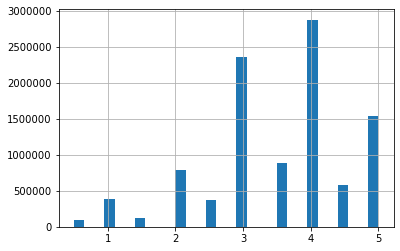

In [9]:
ratings.rating.hist(bins=30)

## Generar índices de peliculas y usuarios

In [13]:
ratings['movie_id'] = ratings['movie_id'].astype("category")
ratings['movie_idx'] = ratings['movie_id'].cat.codes

movie_dict = pd.concat([ratings['movie_id'], ratings['movie_idx']], axis=1)
movie_dict.rename(columns={0: 'id'}, inplace=True)

movie_dict = movie_dict.drop_duplicates().sort_values(by='movie_idx')
movie_dict.set_index('movie_idx', inplace=True)

ratings['user_id'] = ratings['user_id'].astype("category")
ratings['user_idx'] = ratings['user_id'].cat.codes

user_dict = pd.concat([ratings['user_id'], ratings['user_idx']], axis=1)
user_dict.rename(columns={0: 'id'}, inplace=True)

user_dict = user_dict.drop_duplicates().sort_values(by='user_idx')
user_dict.set_index('user_idx', inplace=True)

In [14]:
ratings.head()

,user_id,movie_id,rating,movie_idx,user_idx
0,2,648,2.0,640,1
1,2,802,2.0,789,1
2,2,858,2.0,843,1
3,3,1552,2.0,1502,2
4,3,5505,2.0,5409,2


In [11]:
ratings.head()

,user_id,movie_id,rating,movie_idx,user_idx
0,6,4369,2.0,4276,5
1,8,4992,2.0,4898,7
2,8,5609,2.0,5511,7
3,8,5833,2.0,5735,7
4,12,3593,2.0,3504,11


## Generar preference

In [15]:
ratings_matrix = pd.pivot_table(ratings, index='movie_idx', columns='user_idx', values='rating')

In [16]:
sparcity = round(100 * ratings_matrix.isna().sum().sum() / ratings_matrix.size, 2)
print(f'sparcity = {sparcity}%')

sparcity = 98.66%


In [17]:
ratings_matrix = ratings_matrix.fillna(0)

In [18]:
def confidence_f(x):
    """
    Maps actual rating to confidence
    """
    return x*np.e**(x**1.2)


rating_thresh = 3.5

ratings_full = ratings_matrix.unstack().to_frame('rating').reset_index()
#Eliminate lukewarm reviews:   rating_thresh - 1   <  x  < rating_thresh
ratings_full = ratings_full[~(  (ratings_full.rating < rating_thresh) & (ratings_full.rating >= rating_thresh - 1) )]

ratings_full['preference'] = ratings_full.eval(f'(rating >= {rating_thresh})').astype('int')

#extract tensors
movie_idx = torch.LongTensor(ratings_full['movie_idx'].values)
user_idx = torch.LongTensor(ratings_full['user_idx'].values)

confidence = torch.Tensor(confidence_f(ratings_full['rating'].values))
preference = torch.Tensor(ratings_full['preference'].values)

ratings_full.head()

,user_idx,movie_idx,rating,preference
0,0,0,0.0,0
1,0,1,0.0,0
2,0,2,0.0,0
3,0,3,0.0,0
4,0,4,0.0,0


In [19]:
confidence.mean()

tensor(15.2641)

# Modelo

## Definir modelo

In [20]:
def trunc_normal_(x, mean=0, std=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)


def embedding(ni:int,nf:int):
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb


class EmbeddingDotBias(nn.Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_users_factors, 
                 n_users, n_items, index_item_matrix, embedding_matrix, y_range=None):
        super().__init__()
        self.y_range = y_range
        #generar embedings de usuarios y bias de usuarios e items
        (self.u_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_users_factors), (n_users, 1), (n_items, 1)]]
        
        self.index_item_matrix = index_item_matrix # N_glosas x Largo_maximo_glosas 
        self.embedding_matrix = embedding_matrix # (N_palabras + 1) x N_latentes
        self.bn1 = nn.BatchNorm1d(num_features=39) #Cuántos features???
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.largo_max_glosas = index_item_matrix.shape[1]
        self.n_latent = embedding_matrix.shape[1]
        #https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d
        kernel_size = self.largo_max_glosas * self.n_latent - n_users_factors + 1
        self.conv = torch.nn.Conv1d(1, 1, kernel_size=kernel_size)

    #BatchNorm -> ReLu -> Dropout
    def forward(self, users, items):

        idx_items = self.index_item_matrix[items] #indices de palabras en las glosas Nitems x Largo_max
        i_weights_full = self.embedding_matrix[idx_items] #latentes de glosas
        i_weights_full = self.bn1(i_weights_full)
        i_weights_full = self.relu(i_weights_full)
        dropout_weights = self.dropout(i_weights_full)
        
        i_weight = self.conv(dropout_weights.reshape((len(items), 1, -1))).squeeze()
        #print(i_weight)
        #Bnorm, Relu, Dropout después de la convolución?
        dot = self.u_weight(users) * i_weight
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        #if res > 1e6 or res < -1e6:
        #    print("res: ", res)
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]
    
    

## Initialize model

In [21]:
n_users_factors = 30
#TODO: pensar en un mejor starting point
model = EmbeddingDotBias(n_users_factors, n_users, n_items, 
                         index_item_matrix, embedding_matrix, 
                         y_range=[-.01, 1.01])



In [22]:
model


EmbeddingDotBias(
  (u_weight): Embedding(69878, 30)
  (u_bias): Embedding(69878, 1)
  (i_bias): Embedding(10681, 1)
  (bn1): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5)
  (conv): Conv1d(1, 1, kernel_size=(11671,), stride=(1,))
)

In [191]:
[(x[0], x[1].shape) for x in model.named_parameters()]



[('u_weight.weight', torch.Size([69878, 30])),
 ('u_bias.weight', torch.Size([69878, 1])),
 ('i_bias.weight', torch.Size([10681, 1])),
 ('bn1.weight', torch.Size([39])),
 ('bn1.bias', torch.Size([39])),
 ('conv.weight', torch.Size([1, 1, 11671])),
 ('conv.bias', torch.Size([1]))]

## Train

Use all positive interactions, but get a sample of negative relationships

In [37]:
sgd_con_step = False
optimizer_sin_scheduler = True
cosine_annealing_scheduler = False

if sgd_con_step:
    learning_rate = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
elif optimizer_sin_scheduler:
    learning_rate = 5e-4
    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate, weight_decay=1e-5)
elif cosine_annealing_scheduler: 
    starting_learning_rate = 1e-3
    tmax = 100 #max number of epochs?
    optimizer = torch.optim.Adam(model.parameters(), 
                                lr=starting_learning_rate)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, tmax)

In [24]:
bs = 10
alpha = 1.0

idx_batchs = np.arange(0, len(ratings_full), bs)
np.random.shuffle(idx_batchs)

#TODO: learning rate finder de FastAI


In [25]:
alpha



1.0

In [27]:
import tqdm

In [38]:
losses = []

n_batches = 50_000#10_000
n_batch = 0
for idxs in tqdm.notebook.tqdm(idx_batchs[:n_batches]):
    
    batch_inds = slice(idxs, idxs+bs)
    users = user_idx[batch_inds]
    items = movie_idx[batch_inds]
    p = preference[batch_inds]
    c = confidence[batch_inds]

    prediction = model(users, items)
    loss = ((1 + alpha*c)*(prediction - p)**2).mean()
    if loss < 0:
        print("=====================================")
        print("loss negativo")
        print("prediction: ", prediction)
        print("p: ", p)
        print("alpha y c:", alpha, c)
        
    if loss > 1e6:
        print("=====================================")
        print("loss mayor a un millón")
        print("prediction: ", prediction)
        print("p: ", p)
        print("alpha y c:", alpha, c)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses += [loss]
    if n_batch % 500 == 0:
        print(np.array([x.detach().numpy() for x in losses])[-50::].mean())
    
    n_batch += 1
    #scheduler.step() cada 100 batches
    if n_batch % 100 == 0:
        if sgd_con_step or cosine_annealing_scheduler:
            scheduler.step()
    
    

0.42002836
0.6413135
6.6277723
3.912541
4.165587
4.20583
0.40433624
0.24816139
4.457549
4.5209947
1.132113
6.625971
5.6478667
1.0464889
3.5594754
6.9887958
0.6081322
4.9494863
6.678513
1.0489292
3.3717105
5.1112094
5.453713
3.322439
1.2145431
0.25288844
0.735197
9.0079775
1.3627539
3.4545677
0.6322451
4.5961866
7.1111064
12.036958
1.3978386
1.6099837
7.8737535
19.292316
1.8877922
3.5045044
3.5006843
1.544167
5.557699
6.2342186
6.428044
1.4241465
3.173884
2.1969786
8.758139
3.3717005
3.714845
5.7975464
0.2018114
2.586174
5.8025446
1.6849197
10.747743
1.1560111
7.7709093
3.8924952
1.3866266
3.1440237
9.441834
15.010664
4.1870904
8.784337
1.693409
0.67018807
3.661379
1.9648093
2.5823905
9.462179
0.7550525
0.9098175
1.0100431
4.796933
2.6363382
1.3890979
5.6738014
5.665616
0.65143347
12.77447
2.5093403
7.609652
1.9856564
3.4918494
10.575802
5.400133
1.5138043
0.67247653
1.4484822
1.1883765
3.4276166
0.6534547
1.7202812
7.3899107
2.9121757
10.179272
4.263484
7.112146



In [39]:
loss


tensor(0.1537, grad_fn=<MeanBackward0>)

In [40]:
prediction

tensor([0.4133, 0.4098, 0.4021, 0.3986, 0.3921, 0.3825, 0.3768, 0.3864, 0.3808,
        0.3758], grad_fn=<AddBackward0>)

In [205]:
p

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

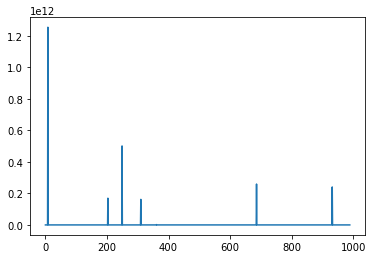

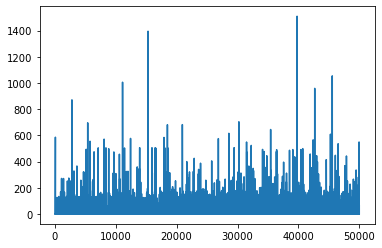

In [41]:
losses = np.array([x.detach().numpy() for x in losses])
plt.plot(losses)



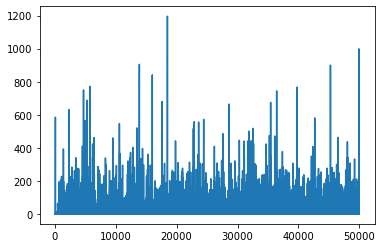

In [32]:
plt.plot(losses[losses > 0])



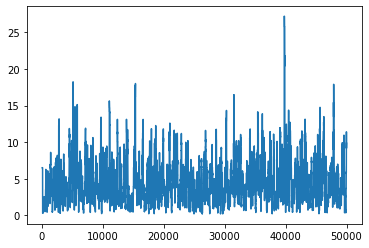

In [42]:
plt.plot(pd.Series(losses[losses >= 0]).rolling(window=100).mean())

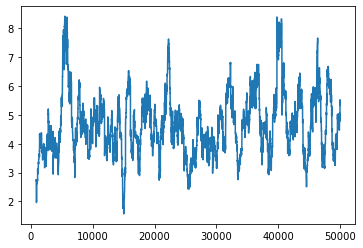

In [43]:
plt.plot(pd.Series(losses[losses >= 0]).rolling(window=800).mean())

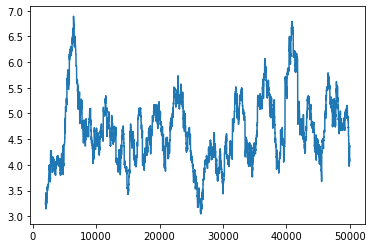

In [44]:
plt.plot(pd.Series(losses[losses >= 0]).rolling(window=2000).mean())